# Analisi dei Dati sul Cinema 

Questo Notebook analizza un dataset riguardante il mondo del cinema, 
comprendente dati relativi a film, attori, crew, recensioni, premi Oscar, release e altro ancora.

Le sezioni principali includono:
- Caricamento e pulizia dei dataset.
- Analisi esplorativa: distribuzione dei rating, trend temporali, analisi geografica delle release.
- Analisi testuale: estrazione e visualizzazione delle parole chiave dalle tagline e descrizioni.
- Integrazione dei dataset di attori e crew per individuare le partecipazioni.


In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from collections import Counter
from nltk.corpus import stopwords

## Funzioni Ausiliarie

Definiamo alcune funzioni utili:
- `convert_date`: converte le colonne data in formato datetime.
- `extract_keywords`: estrae le parole chiave da un testo, considerando solo parole di lunghezza minima.

In [3]:
def extract_keywords(text, min_length=4):
    """
    Estrae parole chiave da un testo: prende le parole con lunghezza maggiore o uguale a min_length.
    Restituisce una lista di parole in minuscolo.
    """
    if pd.isna(text):
        return []
    words = [word.lower() for word in text.split() if len(word) >= min_length]
    return words

In [4]:
def convert_date(df, col):
    """
    Converte la colonna 'col' del DataFrame 'df' in formato datetime.
    """
    df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

In [5]:
def calculate_growth_rate(df, year_col, count_col):
    """
    Calcola il tasso di crescita percentuale del conteggio dei film tra il primo e l'ultimo anno.
    """
    first_year = df[year_col].min()
    last_year = df[year_col].max()
    first_count = df[df[year_col] == first_year][count_col].sum()
    last_count = df[df[year_col] == last_year][count_col].sum()
    if first_count == 0:
        return None
    growth_rate = ((last_count - first_count) / first_count) * 100
    return growth_rate

## Caricamento dei Dataset

Carichiamo i dataset principali

In [6]:
# Caricamento dei dataset principali
movies = pd.read_csv("data/movies.csv")
actors = pd.read_csv("data/actors.csv")
crew = pd.read_csv("data/crew.csv")
reviews = pd.read_csv("data/rotten_tomatoes_reviews.csv")
oscar_awards = pd.read_csv("data/the_oscar_awards.csv")
countries = pd.read_csv("data/countries.csv")
releases = pd.read_csv("data/releases.csv")



## Esplorazione e Pulizia dei Dati

- Verifichiamo ed eventualmento rimuoviamo i valori mancanti.
- Rimuoviamo duplicati.
- Convertiamo le colonne.


In [7]:
# Visualizziamo i valori mancanti per il dataset dei film
print("Valori mancanti in 'movies':")
print(movies.isnull().sum())

# Rimozione dei duplicati
movies.drop_duplicates(subset=["id"], inplace=True)
actors.drop_duplicates(inplace=True)
crew.drop_duplicates(inplace=True)
reviews.drop_duplicates(inplace=True)
oscar_awards.drop_duplicates(inplace=True)
countries.drop_duplicates(inplace=True)
releases.drop_duplicates(inplace=True)

# Conversione delle colonne data
movies = convert_date(movies, 'date')
releases = convert_date(releases, 'date')
reviews = convert_date(reviews, 'review_date')

Valori mancanti in 'movies':
id                  0
name               10
date            91913
tagline        802210
description    160812
minute         181570
rating         850598
dtype: int64


In [8]:
# Statistiche di base
print("\nNumero di film unici:", movies.shape[0])
print("Numero di attori unici:", actors['name'].nunique())
print("Numero di recensioni:", reviews.shape[0])
print("Numero di rilasci unici:", releases.shape[0])
print("Numero di paesi unici:", countries['country'].nunique())


Numero di film unici: 941597
Numero di attori unici: 1600662
Numero di recensioni: 1010416
Numero di rilasci unici: 1332782
Numero di paesi unici: 247


## Analisi Esplorativa

### Distribuzione dei Rating dei Film

Visualizziamo la distribuzione dei rating utilizzando matplotlib.


In [9]:
fig1 = px.histogram(
    movies,
    x="rating",
    nbins=30,
    title="Distribuzione dei Rating dei Film",
    labels={"rating": "Rating", "count": "Numero di Film"},
    color_discrete_sequence=["skyblue"]
)
fig1.update_layout(bargap=0.1)

pio.write_html(fig1, "plot_rating_distribution.html", full_html=False, include_plotlyjs='cdn')



### Trend Temporali

Analizziamo l'evoluzione nel tempo del numero di film e del rating medio.


In [10]:
from datetime import datetime

movies['year'] = pd.to_numeric(movies['date'], errors='coerce')
movies_unique = movies.groupby(['year', 'name']).agg({
    'id': 'first',         
    'rating': 'mean'       
}).reset_index()

movies_unique = movies_unique[(movies_unique['year'] >= 1895) & (movies_unique['year'] <= datetime.now().year)]

movies_yearly = movies_unique.groupby("year").agg({"id": "count", "rating": "mean"}).rename(columns={"id": "num_unique_films", "rating": "avg_rating"}).reset_index()

fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=movies_yearly['year'],
    y=movies_yearly['num_unique_films'],
    name="Numero di Film Unici",
    mode='lines+markers',
    line=dict(color='teal'),
    yaxis="y1"
))
fig2.add_trace(go.Scatter(
    x=movies_yearly['year'],
    y=movies_yearly['avg_rating'],
    name="Rating Medio",
    mode='lines+markers',
    line=dict(color='coral'),
    yaxis="y2"
))

fig2.update_layout(
    title="Trend Temporali: Numero di Film e Rating Medio per Anno",
    xaxis=dict(title="Anno"),
    yaxis=dict(
    title=dict(text="Numero di Film", font=dict(color='teal')),
    tickfont=dict(color='teal')
),
yaxis2=dict(
    title=dict(text="Rating Medio", font=dict(color='coral')),
    tickfont=dict(color='coral'),
    overlaying='y',
    side='right'
),
    legend=dict(x=0.1, y=1.1, orientation='h'),
    hovermode="x unified"
)

pio.write_html(fig2, "plot_trend_temporali.html", full_html=False, include_plotlyjs='cdn')

### Analisi Geografica delle Release

Possiamo visualizzare un bar chart con il numero di film per paese.

In [11]:
country_counts = countries['country'].value_counts()

fig3 = go.Figure(data=[go.Bar(
    x=country_counts.index,
    y=country_counts.values,
    marker_color='navy'
)])

fig3.update_layout(
    title="Numero di Film per Paese (Release)",
    xaxis_title="Paese",
    yaxis_title="Numero di Film",
    xaxis_tickangle=45
)

pio.write_html(fig3, "plot_films_per_country.html", full_html=False, include_plotlyjs='cdn')

### Analisi delle Frequenze delle Parole Chiave

Estraiamo le parole chiave dalle tagline e dalle descrizioni dei film e visualizziamo le 20 parole più frequenti.

In [16]:


stop_words = set(stopwords.words('english'))

def extract_keywords_filtered(text):
    # Semplice split per tokenizzazione (puoi migliorare con nltk.word_tokenize)
    words = text.lower().split()
    # Rimuovi stopwords e parole molto corte (<=2 lettere)
    filtered_words = [w for w in words if w.isalpha() and w not in stop_words and len(w) > 2]
    return filtered_words

movies['combined_text'] = movies['tagline'].fillna('') + " " + movies['description'].fillna('')

all_words = []
movies['combined_text'].apply(lambda x: all_words.extend(extract_keywords_filtered(x)))

word_counts = Counter(all_words)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

fig4 = go.Figure(data=[go.Bar(
    x=words,
    y=counts,
    marker_color='purple'
)])

fig4.update_layout(
    title="Top 20 Parole Chiave in Tagline e Descrizioni",
    xaxis_title="Parola",
    yaxis_title="Frequenza",
    xaxis_tickangle=45
)

pio.write_html(fig4, "plot_top_keywords.html", full_html=False, include_plotlyjs='cdn')

print("Top 20 parole chiave:", top_words)


Top 20 parole chiave: [('film', 123357), ('one', 104219), ('young', 80720), ('life', 77235), ('two', 71343), ('new', 69793), ('story', 66358), ('man', 60932), ('love', 57529), ('world', 48132), ('documentary', 44808), ('first', 44586), ('family', 40547), ('find', 40351), ('time', 39115), ('woman', 39012), ('years', 38019), ('get', 37715), ('people', 36945), ('short', 35763)]


### Integrazione maggiori Apparizioni tra Cast e Crew

Calcoliamo il numero di apparizioni nei dataset di attori e crew, 
poi visualizziamo le top 10 persone con il maggior numero di apparizioni in generale.

In [21]:
actors_counts = actors['name'].value_counts().reset_index()
actors_counts.columns = ['name', 'appearances']

crew_counts = crew['name'].value_counts().reset_index()
crew_counts.columns = ['name', 'appearances']

combined_people = pd.merge(actors_counts, crew_counts, on="name", how="outer", suffixes=("_actor", "_crew")).fillna(0)
combined_people["total_appearances"] = combined_people["appearances_actor"] + combined_people["appearances_crew"]

top_people = combined_people.sort_values("total_appearances", ascending=False).head(10)

fig5 = go.Figure(data=[go.Bar(
    y=top_people["name"],
    x=top_people["total_appearances"],
    orientation='h',
    marker_color='orange'
)])

fig5.update_layout(
    title="Top 10 Persone (Attori + Crew) per Numero di Apparizioni",
    xaxis_title="Numero di Apparizioni",
    yaxis_title="Nome",
    yaxis=dict(autorange="reversed")  # Per avere massimo in alto
)

pio.write_html(fig5, "plot_top_people.html", full_html=False, include_plotlyjs='cdn')

print("Top 10 persone (attori e crew) per apparizioni:")
print(top_people)

Top 10 persone (attori e crew) per apparizioni:
                        name  appearances_actor  appearances_crew  \
1393406        Louis Lumière                4.0            1176.0   
225111       Auguste Lumière               10.0            1072.0   
1579689            Mel Blanc             1058.0               0.0   
848644        Gérard Courant               67.0             965.0   
805302   Gilbert M. Anderson              343.0             685.0   
2368548          Walt Disney              241.0             725.0   
376289        Cedric Gibbons                3.0             836.0   
1432955         Mack Sennett              241.0             506.0   
273822          Bess Flowers              696.0               0.0   
932753           Ilaiyaraaja                6.0             680.0   

         total_appearances  
1393406             1180.0  
225111              1082.0  
1579689             1058.0  
848644              1032.0  
805302              1028.0  
2368548           

### Calcolo del Tasso di Crescita del Numero di Film

In [20]:
import datetime
current_year = datetime.datetime.now().year

movies_filtered = movies[(movies['year'] >= 1900) & (movies['year'] <= current_year)]
film_per_year = movies_filtered.groupby('year').size().sort_index()

# Calcolo crescita anno su anno
growth_rates = film_per_year.pct_change().dropna() * 100

avg_growth = growth_rates.mean()

print(f"Crescita percentuale media annua: {avg_growth:.2f}%")


Crescita percentuale media annua: 3.04%


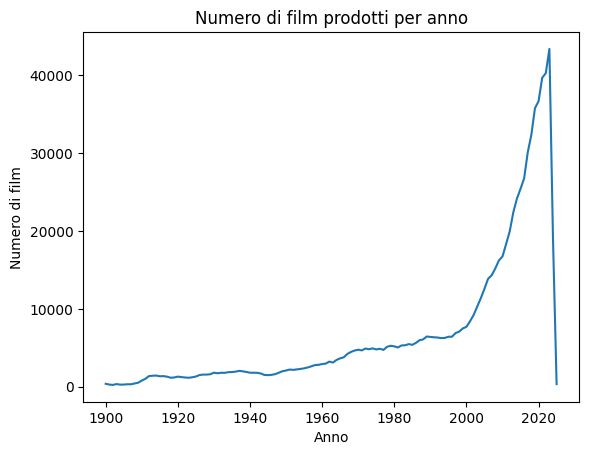

In [21]:
import matplotlib.pyplot as plt

film_per_year.plot(title="Numero di film prodotti per anno")
plt.xlabel("Anno")
plt.ylabel("Numero di film")
plt.show()


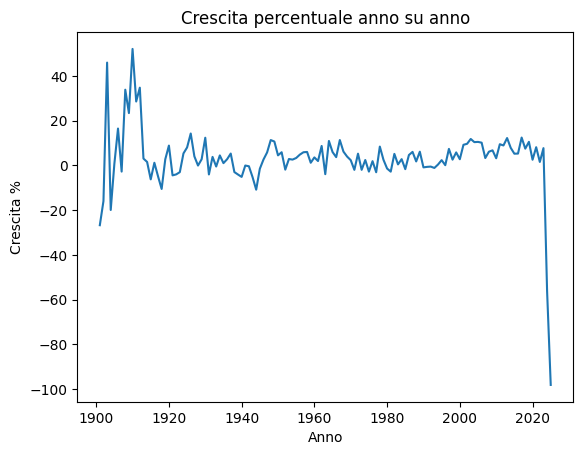

In [22]:
growth_rates.plot(title="Crescita percentuale anno su anno")
plt.xlabel("Anno")
plt.ylabel("Crescita %")
plt.show()
